#### Compare imputation strategies by defining different pipelines and grid searches and find best pipeline and best estimator for variable y=G1, on dataset with reduced variables. Create additional architecture with Batch Normaliation layer to compare performance.

matplotlib, seaborn

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style('darkgrid')
plt.rcParams['figure.dpi']=150 #resolution in dots per inch

numpy, pandas

In [2]:
import numpy as np
import pandas as pd

from numpy import asarray
from numpy import save
from numpy import load
from numpy import isnan

In [3]:
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
# MinMaxScaler() normalizes, range on the training set, default=(0, 1)

imputers

In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.impute import KNNImputer

import miceforest as mf #multiple imputer

validation methods`

In [5]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

tensorflow

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization

pipeline

In [7]:
from sklearn.pipeline import make_pipeline, Pipeline
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [9]:
#script, function for confusion matrix
%run -i show_confusion_matrix.py

In [10]:
#load data
data = pd.read_csv('data2_droplists.csv')
#make sure dataset has only numbers
data = data.apply(pd.to_numeric)
data.shape

(1838, 668)

In [11]:
#split to dependent and independent variables
X = data.loc[:, data.columns != 'G1'].values #select all but the desired G1 for y { 0 :'None', 1 :'Questionable', 2 :'Mild', 3 :'Moderate', 4 :'Severe'}
y = data['G1'].values

print(X.shape,y.shape)

(1838, 667) (1838,)


In [12]:
#find unique values for NN output layer
data['G1'].value_counts()

0.0    1514
1.0     240
2.0      59
3.0      14
4.0      11
Name: G1, dtype: int64

In [13]:
#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10, shuffle=True, stratify=y)


In [14]:
# determine the number of input features for NN input layer
n_features = X.shape[1]

In [15]:
#model definition of NN with possible parameters as arguments

def create_nn(activation = 'relu', 
              optimizer='adam', 
              init='he_normal', 
              layer1_units=64,
              layer2_units=32,
              hidden_layers=1, 
              dropout_rate=0.5):
    # create model
    model = Sequential()
    
    if activation=='relu':
        # Add an input layer
        model.add(Dense(units=layer1_units, 
                        kernel_initializer=init, 
                        activation='relu', 
                        input_shape=(n_features,)))
        for i in range(hidden_layers): # Add hidden layer
            model.add(Dense(layer2_units, 
                        kernel_initializer=init, 
                        activation='relu'))
        
        model.add(Dropout(rate=dropout_rate))
        # Add an output layer
        model.add(Dense(5, activation='softmax'))
        
    if activation=='tanh':
        # Add input layer, giving number of features
        model.add(Dense(layer1_units, 
                        kernel_initializer=init, 
                        activation='tanh', 
                        input_shape=(n_features,)))
        for i in range(hidden_layers): # Add hidden layer based on possible numbers in the grid
            model.add(Dense(layer2_units, 
                        kernel_initializer=init, 
                        activation='tanh'))
        
        model.add(Dropout(rate=dropout_rate))
        # Add output layer for 5 classes of G1, activation has to be softmax for multiclass
        model.add(Dense(5, activation='softmax'))
    
    # Compile model
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['sparse_categorical_accuracy']) # 'sparse_categorical_accuracy' because of chosen loss metric
    
    return model
      


In [16]:
#wrap the model create function in KerasClassifier class so as to be able to use with grid search
model_wrap = KerasClassifier(build_fn=create_nn, 
                             activation = 'relu', 
                             optimizer='adam', 
                             init='he_normal', 
                             layer1_units=64,
                             layer2_units=32,
                             hidden_layers=1, 
                             dropout_rate=0.5, 
                             batch_size=32, 
                             epochs=10, 
                             verbose=0)

In [17]:
#pipeline for iterative imputation
pipeline_iter = Pipeline([
    ('scaler', MinMaxScaler()),
    ('imputer', IterativeImputer(max_iter=10,n_nearest_features=200,initial_strategy='most_frequent',imputation_order='ascending')),
    ('model', model_wrap)])
#pipeline for knn imputation
pipeline_knn = Pipeline([
    ('scaler', MinMaxScaler()),
    ('imputer', KNNImputer()),
    ('model', model_wrap)])

In [18]:
#define all grid parameters to search over
param_grid_iter ={
    'scaler': [MinMaxScaler()],
    'model__activation' : ['tanh','relu'],
    'model__optimizer' : ['adam','sgd'],
    'model__init' : ['he_normal'], 
    'model__epochs' : [40],
    'model__batch_size' : [16],
    'model__hidden_layers' : [3],
    'model__dropout_rate' : [0.5,0.7],
    'model__layer1_units' : [32],
    'model__layer2_units' : [32]
    
}

param_grid_knn ={
    'scaler': [MinMaxScaler()], 
    'imputer__n_neighbors' : [3,5,9],
    'model__activation' : ['tanh','relu'],
    'model__optimizer' : ['adam','sgd'],
    'model__init' : ['he_normal'], 
    'model__epochs' : [40],
    'model__batch_size' : [16],
    'model__hidden_layers' : [3],
    'model__dropout_rate' : [0.5,0.7],
    'model__layer1_units' : [32],
    'model__layer2_units' : [32]
    
}

In [19]:
#define the grid and insert pipeline in place of the estimator 
grid_iter = GridSearchCV(estimator=pipeline_iter, 
                    param_grid=param_grid_iter, 
                    scoring='accuracy', 
                    cv = 10,
                    verbose=1,)

grid_knn = GridSearchCV(estimator=pipeline_knn, 
                    param_grid=param_grid_knn, 
                    scoring='accuracy', 
                    cv = 10,
                    verbose=1,)

###### run grid iter

In [20]:
import time
start_time = time.time()

grid_iter.fit(X_train, y_train)
    
#calculate time for fit function
elapsed_time = time.time() - start_time
print(elapsed_time, "seconds for fitting iter gridsearch")

Fitting 10 folds for each of 8 candidates, totalling 80 fits


C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: C

C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: C

C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\impute\_iterative.py:701: C

25415.79669213295 seconds for fitting iter gridsearch


###### run grid knn

In [21]:
start_time = time.time()

grid_knn.fit(X_train, y_train)
    
#calculate time for fit function
elapsed_time = time.time() - start_time
print(elapsed_time, "seconds for fitting iter gridsearch")

Fitting 10 folds for each of 24 candidates, totalling 240 fits
2855.588425397873 seconds for fitting iter gridsearch


##### iterative results

In [22]:
print('Best Iterative imputer params are :\n %s' % grid_iter.best_params_)
# Best training data accuracy
print('\nBest training accuracy: %.3f' % grid_iter.best_score_)
# Predict on test data with best params
y_pred_iter = grid_iter.predict(X_test)
# Test data accuracy of model with best params
print('\nTest set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred_iter))

Best Iterative imputer params are :
 {'model__activation': 'relu', 'model__batch_size': 16, 'model__dropout_rate': 0.5, 'model__epochs': 40, 'model__hidden_layers': 3, 'model__init': 'he_normal', 'model__layer1_units': 32, 'model__layer2_units': 32, 'model__optimizer': 'sgd', 'scaler': MinMaxScaler()}

Best training accuracy: 0.903

Test set accuracy score for best params: 0.883 


In [23]:
#evaluation metrics on test set predictions
print("ITERATIVE IMPUTATION RESULTS")
print('\n',confusion_matrix(y_test, y_pred_iter))
print('\n',classification_report(y_test, y_pred_iter))

ITERATIVE IMPUTATION RESULTS

 [[283  19   1   0   0]
 [ 11  34   3   0   0]
 [  0   2   7   3   0]
 [  0   0   2   0   1]
 [  0   0   0   1   1]]

               precision    recall  f1-score   support

         0.0       0.96      0.93      0.95       303
         1.0       0.62      0.71      0.66        48
         2.0       0.54      0.58      0.56        12
         3.0       0.00      0.00      0.00         3
         4.0       0.50      0.50      0.50         2

    accuracy                           0.88       368
   macro avg       0.52      0.55      0.53       368
weighted avg       0.89      0.88      0.89       368



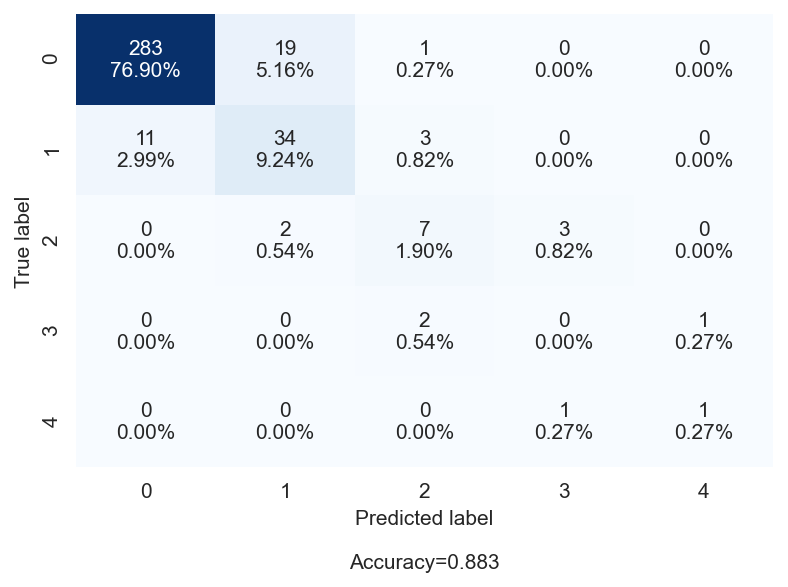

In [24]:
cf_matrix_iter = confusion_matrix(y_test, y_pred_iter)
make_confusion_matrix(cf_matrix_iter, figsize=(6,4), cbar=False)

In [25]:
#extract results to put on a dataframe
means_iter = grid_iter.cv_results_['mean_test_score']
stds_iter = grid_iter.cv_results_['std_test_score']
params_iter = grid_iter.cv_results_['params']

In [26]:
#make df
df_iter=pd.DataFrame(params_iter)
df_iter['Mean']=means_iter
df_iter['Std. Dev']=stds_iter

In [27]:
#save df to file
df_iter.to_csv(r'C:\Users\redi\Desktop\Βαρλαμης\data\grid_G1_df_iter.csv',index=False, float_format='%.4f')
df_iter

,model__activation,model__batch_size,model__dropout_rate,model__epochs,model__hidden_layers,model__init,model__layer1_units,model__layer2_units,model__optimizer,scaler,Mean,Std. Dev
0,tanh,16,0.5,40,3,he_normal,32,32,adam,MinMaxScaler(),0.898639,0.013068
1,tanh,16,0.5,40,3,he_normal,32,32,sgd,MinMaxScaler(),0.893197,0.020192
2,tanh,16,0.7,40,3,he_normal,32,32,adam,MinMaxScaler(),0.892517,0.016327
3,tanh,16,0.7,40,3,he_normal,32,32,sgd,MinMaxScaler(),0.889116,0.027219
4,relu,16,0.5,40,3,he_normal,32,32,adam,MinMaxScaler(),0.897959,0.017998
5,relu,16,0.5,40,3,he_normal,32,32,sgd,MinMaxScaler(),0.903401,0.021034
6,relu,16,0.7,40,3,he_normal,32,32,adam,MinMaxScaler(),0.893197,0.022158
7,relu,16,0.7,40,3,he_normal,32,32,sgd,MinMaxScaler(),0.887075,0.026206


##### knn results

In [28]:
print('Best Knn imputer params are :\n %s' % grid_knn.best_params_)
# Best training data accuracy
print('\nBest training accuracy: %.3f' % grid_knn.best_score_)
# Predict on test data with best params
y_pred_knn = grid_knn.predict(X_test)
# Test data accuracy of model with best params
print('\nTest set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred_knn))

Best Knn imputer params are :
 {'imputer__n_neighbors': 3, 'model__activation': 'relu', 'model__batch_size': 16, 'model__dropout_rate': 0.5, 'model__epochs': 40, 'model__hidden_layers': 3, 'model__init': 'he_normal', 'model__layer1_units': 32, 'model__layer2_units': 32, 'model__optimizer': 'adam', 'scaler': MinMaxScaler()}

Best training accuracy: 0.911

Test set accuracy score for best params: 0.910 


In [29]:
#evaluation metrics on test set predictions
print("KNN IMPUTATION RESULTS")
print('\n',confusion_matrix(y_test, y_pred_knn))
print('\n',classification_report(y_test, y_pred_knn))

KNN IMPUTATION RESULTS

 [[296   7   0   0   0]
 [ 15  32   1   0   0]
 [  1   5   5   1   0]
 [  0   0   2   0   1]
 [  0   0   0   0   2]]

               precision    recall  f1-score   support

         0.0       0.95      0.98      0.96       303
         1.0       0.73      0.67      0.70        48
         2.0       0.62      0.42      0.50        12
         3.0       0.00      0.00      0.00         3
         4.0       0.67      1.00      0.80         2

    accuracy                           0.91       368
   macro avg       0.59      0.61      0.59       368
weighted avg       0.90      0.91      0.90       368



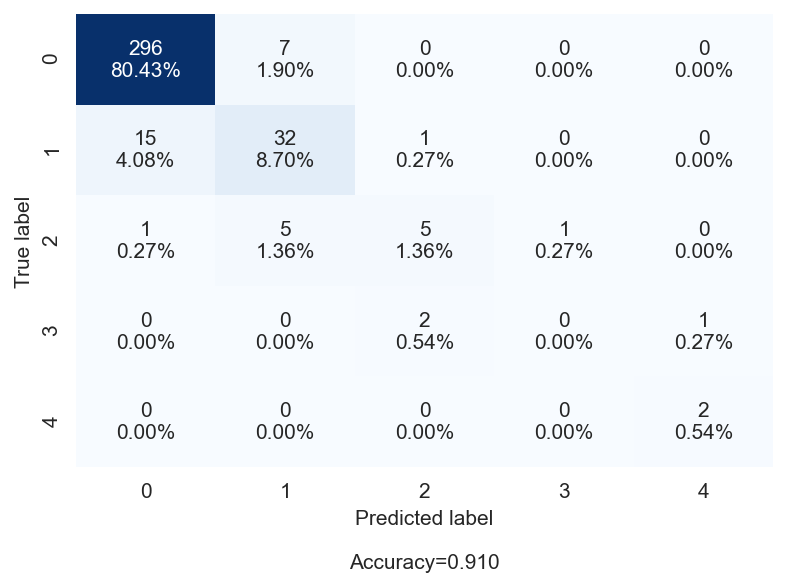

In [30]:
cf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
make_confusion_matrix(cf_matrix_knn, figsize=(6,4), cbar=False)

In [31]:
#extract results to put on a dataframe
means_knn = grid_knn.cv_results_['mean_test_score']
stds_knn = grid_knn.cv_results_['std_test_score']
params_knn = grid_knn.cv_results_['params']


In [32]:
df_knn=pd.DataFrame(params_knn)
df_knn['Mean']=means_knn
df_knn['Std. Dev']=stds_knn

In [33]:
#save df to file
df_knn.to_csv(r'C:\Users\redi\Desktop\Βαρλαμης\data\grid_G1_df_knn.csv',index=False, float_format='%.4f')
df_iter

,model__activation,model__batch_size,model__dropout_rate,model__epochs,model__hidden_layers,model__init,model__layer1_units,model__layer2_units,model__optimizer,scaler,Mean,Std. Dev
0,tanh,16,0.5,40,3,he_normal,32,32,adam,MinMaxScaler(),0.898639,0.013068
1,tanh,16,0.5,40,3,he_normal,32,32,sgd,MinMaxScaler(),0.893197,0.020192
2,tanh,16,0.7,40,3,he_normal,32,32,adam,MinMaxScaler(),0.892517,0.016327
3,tanh,16,0.7,40,3,he_normal,32,32,sgd,MinMaxScaler(),0.889116,0.027219
4,relu,16,0.5,40,3,he_normal,32,32,adam,MinMaxScaler(),0.897959,0.017998
5,relu,16,0.5,40,3,he_normal,32,32,sgd,MinMaxScaler(),0.903401,0.021034
6,relu,16,0.7,40,3,he_normal,32,32,adam,MinMaxScaler(),0.893197,0.022158
7,relu,16,0.7,40,3,he_normal,32,32,sgd,MinMaxScaler(),0.887075,0.026206


### Try Batch Norm layer

In [34]:
#model definition of NN with Batch notmaliation Layer

def create_nn_batch_norm(activation = 'relu', 
              optimizer='adam', 
              init='he_normal', 
              layer1_units=64, 
              layer2_units=32, 
              hidden_layers=1, 
              dropout_rate=0):
    # create model
    model = Sequential()

    model.add(Dense(units=layer1_units, 
                        kernel_initializer=init, 
                        activation='relu', 
                        input_shape=(n_features,)))
    model.add(BatchNormalization())
    for i in range(hidden_layers): # Add hidden layer
        model.add(Dense(layer2_units, 
                    kernel_initializer=init, 
                    activation='relu'))
        
    model.add(BatchNormalization())
    # Add an output layer
    model.add(Dense(5, activation='softmax'))
   
    # Add output layer for 5 classes of G1, activation has to be softmax for multiclass
    model.add(Dense(5, activation='softmax'))
    
    # Compile model
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['sparse_categorical_accuracy']) # 'sparse_categorical_accuracy' because of chosen loss metric
    
    return model
      


In [35]:
#wrap the model create function in KerasClassifier class so as to be able to use with grid search
model_batch_wrap = KerasClassifier(build_fn=create_nn_batch_norm, 
                             activation = 'relu', 
                             optimizer='adam', 
                             init='he_normal', 
                             layer1_units=32,
                             layer2_units=32,
                             hidden_layers=1,                             
                             batch_size=32, 
                             epochs=10, 
                             verbose=0)

In [36]:
#create a basic pipeline for scaling and imputation
pipeline_batch = Pipeline([
    ('scaler', MinMaxScaler()),
    ('imputer',  KNNImputer()),
    ('model', model_batch_wrap)])

In [38]:
#define all grid parameters to search over
param_grid_batch = {
    'scaler': [MinMaxScaler()], 
    'imputer__n_neighbors' : [3],
    'model__activation' : ['relu'],
    'model__optimizer' : ['adam'],
    'model__init' : ['he_normal'], 
    'model__epochs' : [40],
    'model__batch_size' : [16],
    'model__hidden_layers' : [3],
    'model__layer1_units' : [32],
    'model__layer2_units' : [32]
    
}
grid_batch = GridSearchCV(estimator=pipeline_batch, 
                    param_grid=param_grid_batch, 
                    scoring='accuracy', 
                    cv = 10,
                    verbose=1,)

In [39]:
import time
start_time = time.time()

#fit grid search on training data
grid_batch.fit(X_train, y_train)

#calculate time for fit function
elapsed_time = time.time() - start_time
print(elapsed_time, "seconds for fitting batch norm gridsearch")

Fitting 10 folds for each of 1 candidates, totalling 10 fits
ERROR! Session/line number was not unique in database. History logging moved to new session 1182
157.07748413085938 seconds for fitting batch norm gridsearch


In [40]:
print('Best batch norm params are :\n %s' % grid_batch.best_params_)
# Best training data accuracy
print('\nBest training accuracy: %.3f' % grid_batch.best_score_)
# Predict on test data with best params
y_pred_batch = grid_batch.predict(X_test)
# Test data accuracy of model with best params
print('\nTest set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred_knn))

Best batch norm params are :
 {'imputer__n_neighbors': 3, 'model__activation': 'relu', 'model__batch_size': 16, 'model__epochs': 40, 'model__hidden_layers': 3, 'model__init': 'he_normal', 'model__layer1_units': 32, 'model__layer2_units': 32, 'model__optimizer': 'adam', 'scaler': MinMaxScaler()}

Best training accuracy: 0.880

Test set accuracy score for best params: 0.910 


In [42]:
#evaluation metrics on test set predictions
print("BATCH NORM RESULTS")
print('\n',confusion_matrix(y_test, y_pred_batch))
print('\n',classification_report(y_test, y_pred_batch))

BATCH NORM RESULTS

 [[290   9   4   0   0]
 [ 17  16  15   0   0]
 [  0   3   9   0   0]
 [  0   0   3   0   0]
 [  0   0   2   0   0]]

               precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       303
         1.0       0.57      0.33      0.42        48
         2.0       0.27      0.75      0.40        12
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00      0.00         2

    accuracy                           0.86       368
   macro avg       0.36      0.41      0.35       368
weighted avg       0.86      0.86      0.85       368



C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\redi\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


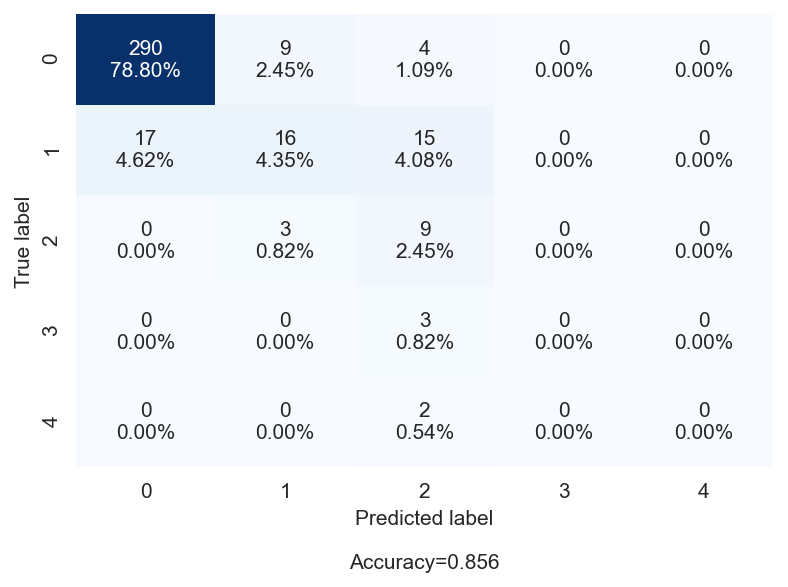

In [43]:
cf_matrix_batch = confusion_matrix(y_test, y_pred_batch)
make_confusion_matrix(cf_matrix_batch, figsize=(6,4), cbar=False)

In [44]:
#extract results to put on a dataframe
means_batch = grid_batch.cv_results_['mean_test_score']
stds_batch = grid_batch.cv_results_['std_test_score']
params_batch = grid_batch.cv_results_['params']

In [45]:
df_batch=pd.DataFrame(params_batch)
df_batch['Mean']=means_batch
df_batch['Std. Dev']=stds_batch

In [46]:
#save df to file
df_batch.to_csv(r'C:\Users\redi\Desktop\Βαρλαμης\data\grid_G1_df_batch.csv',index=False, float_format='%.4f')
df_batch

,imputer__n_neighbors,model__activation,model__batch_size,model__epochs,model__hidden_layers,model__init,model__layer1_units,model__layer2_units,model__optimizer,scaler,Mean,Std. Dev
0,3,relu,16,40,3,he_normal,32,32,adam,MinMaxScaler(),0.880272,0.012245


#### violin plots of different parameters in gridsearch with accuracy

In [47]:
d = pd.read_csv('grid_G1_df_iter.csv')

Plots from iterative imputer grid


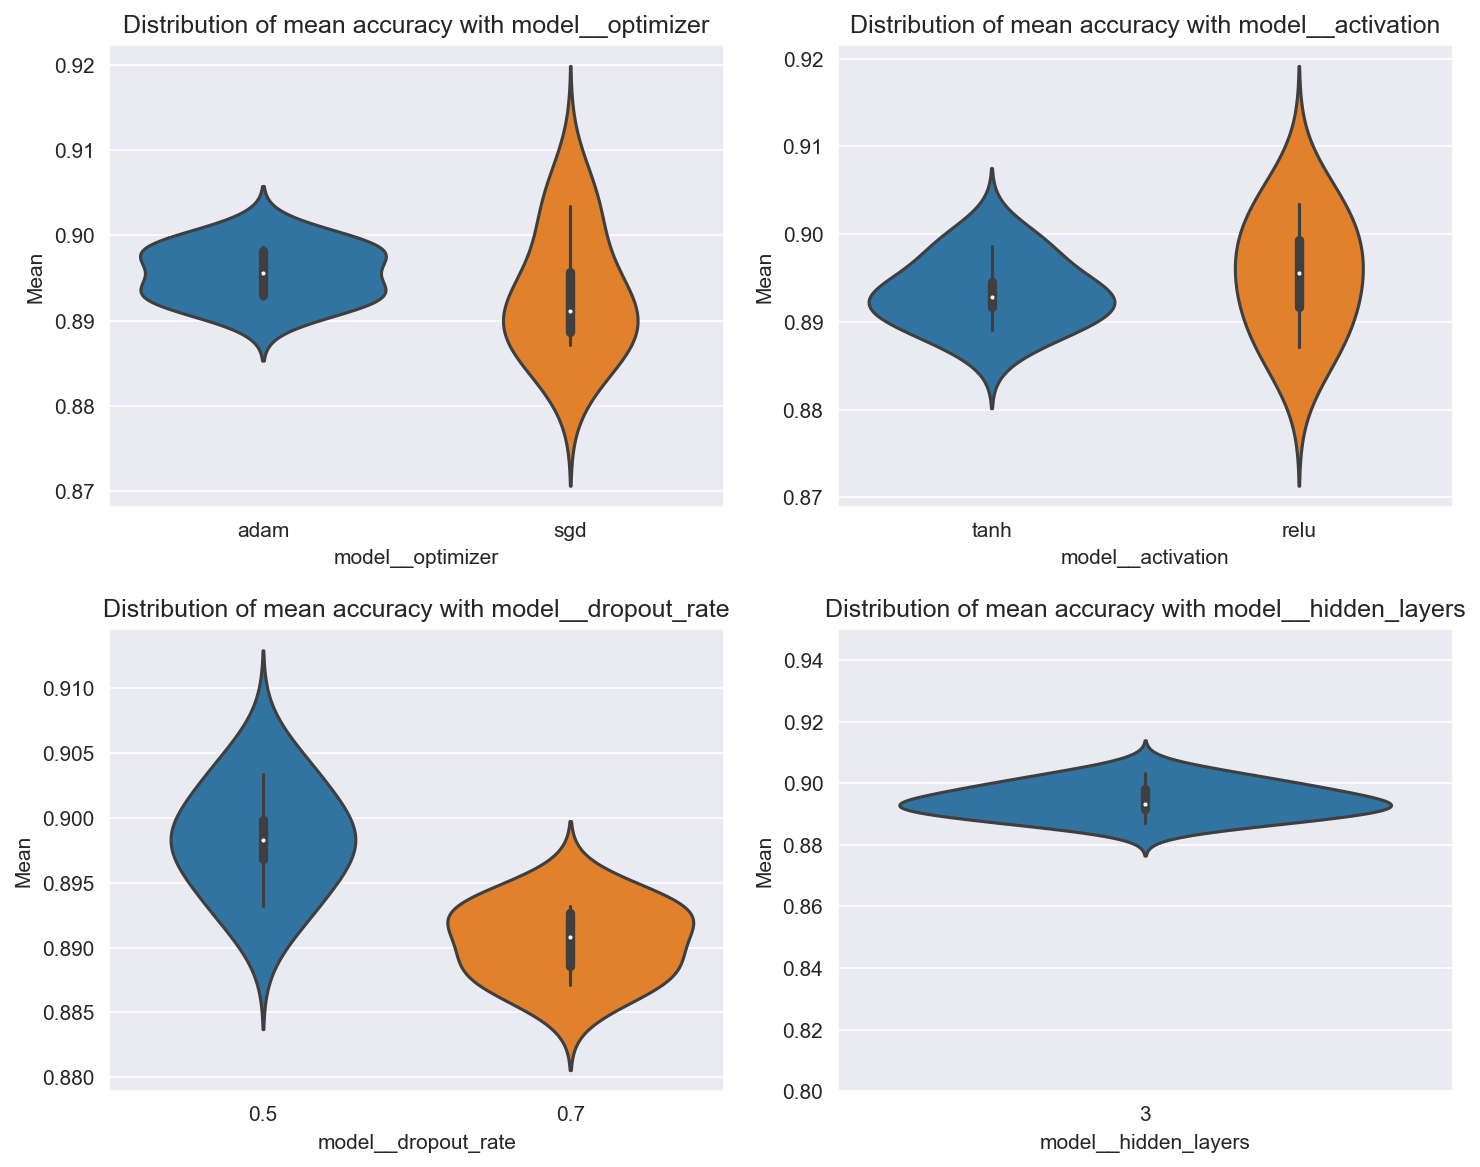

In [48]:
#get specific parameters to plot
params_ = ['model__optimizer','model__activation','model__dropout_rate', 'model__hidden_layers']

#violin plots 
fig, ax = plt.subplots(2,2,figsize=(10,8), squeeze=True)
ax = ax.ravel()
plt.ylim(0.8, 0.95)
for i in range(4):
    ax[i].set_title('Distribution of mean accuracy with {}'.format(params_[i]))
    sns.violinplot(x=params_[i],y='Mean',data=d,cut=3,ax=ax[i])   
fig.tight_layout(pad=1.5)

print("Plots from iterative imputer grid")

In [49]:
d = pd.read_csv('grid_G1_df_knn.csv')

Plots from knn imputer grid


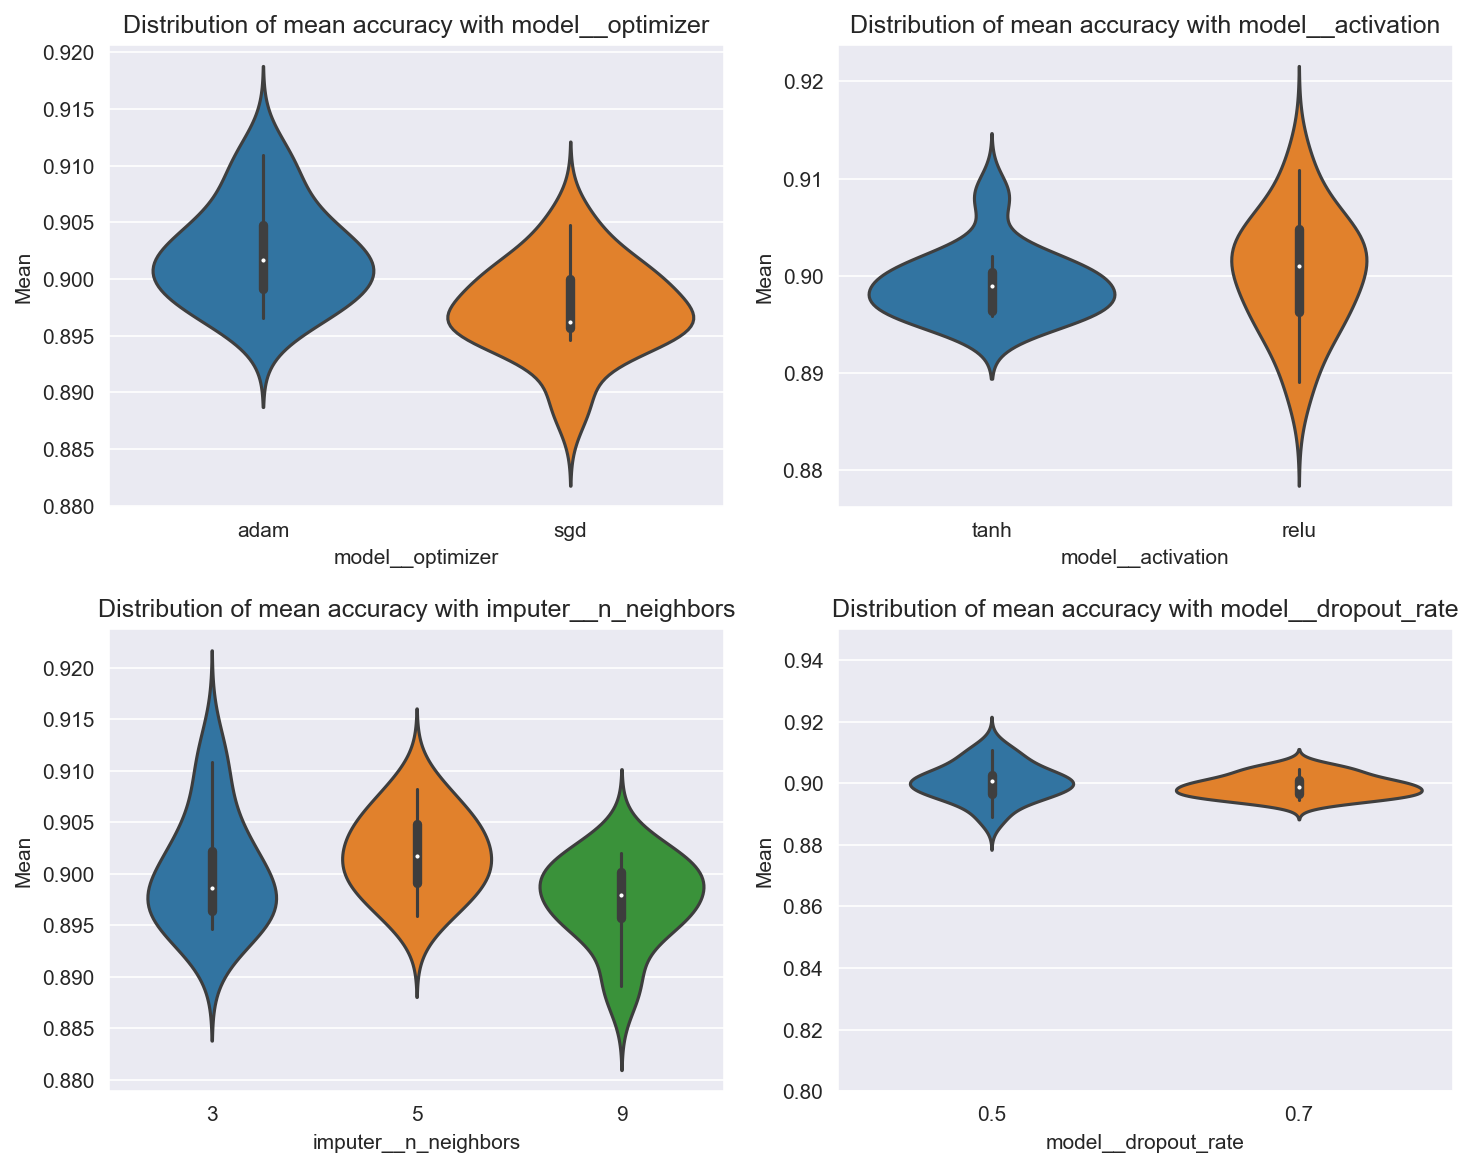

In [50]:
#get specific parameters to plot
params_ = ['model__optimizer','model__activation','imputer__n_neighbors','model__dropout_rate']

#violin plots
fig, ax = plt.subplots(2,2,figsize=(10,8), squeeze=True)
ax = ax.ravel()
plt.ylim(0.8, 0.95)
for i in range(4):
    ax[i].set_title('Distribution of mean accuracy with {}'.format(params_[i]))
    sns.violinplot(x=params_[i],y='Mean',data=d,cut=3,ax=ax[i])   
fig.tight_layout(pad=1.5)

print("Plots from knn imputer grid")